# A project of Rodolfo Petrelli, Filippo Scaramozzino and Badreddine Ainane

In this project, we fit Random Forest, K-Nearest Neighbors (KNN), and Neural Network models to solve a drug prediction task. We also experiment with variations, such as changing activation functions, and use a validation set to identify the best-performing model. Finally, we apply Principal Component Analysis (PCA) and K-Means clustering for exploratory data analysis and pattern discovery.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

# Check for errors in the dataset

In [3]:
df_drug = pd.read_csv("drug200.csv")

In [4]:
df_drug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [5]:
df_drug.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [6]:
# Descriptive Statistics for the numerical features
df_drug.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [7]:
# Check if any missing value
df_drug.isnull().sum()

,0
Age,0
Sex,0
BP,0
Cholesterol,0
Na_to_K,0
Drug,0


Other methods to check missing values

In [8]:
df_drug[['Age', 'Na_to_K']]==0

,Age,Na_to_K
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
195,False,False
196,False,False
197,False,False
198,False,False


In [9]:
val = ['Age', 'Na_to_K']
for i in val:
    z = 0
    for x in (df_drug[i]):
        if x == 0:
            z = z + 1
    print(i,z)

Age 0
Na_to_K 0


By putting numerical columns equal to 0 we just double-checked for missing value by identifying zeros as missing as isnull method only detects NaN values. In this case this procedure is redundant to show as the output for the two features is 0 with both procedures.

In [10]:
# Value count for categorical features

for col in ['Sex', 'BP', 'Cholesterol', 'Drug']:
    print(f"\n{df_drug[col].value_counts()}")


Sex
M    104
F     96
Name: count, dtype: int64

BP
HIGH      77
LOW       64
NORMAL    59
Name: count, dtype: int64

Cholesterol
HIGH      103
NORMAL     97
Name: count, dtype: int64

Drug
drugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: count, dtype: int64


## Exploratory Data Analysis


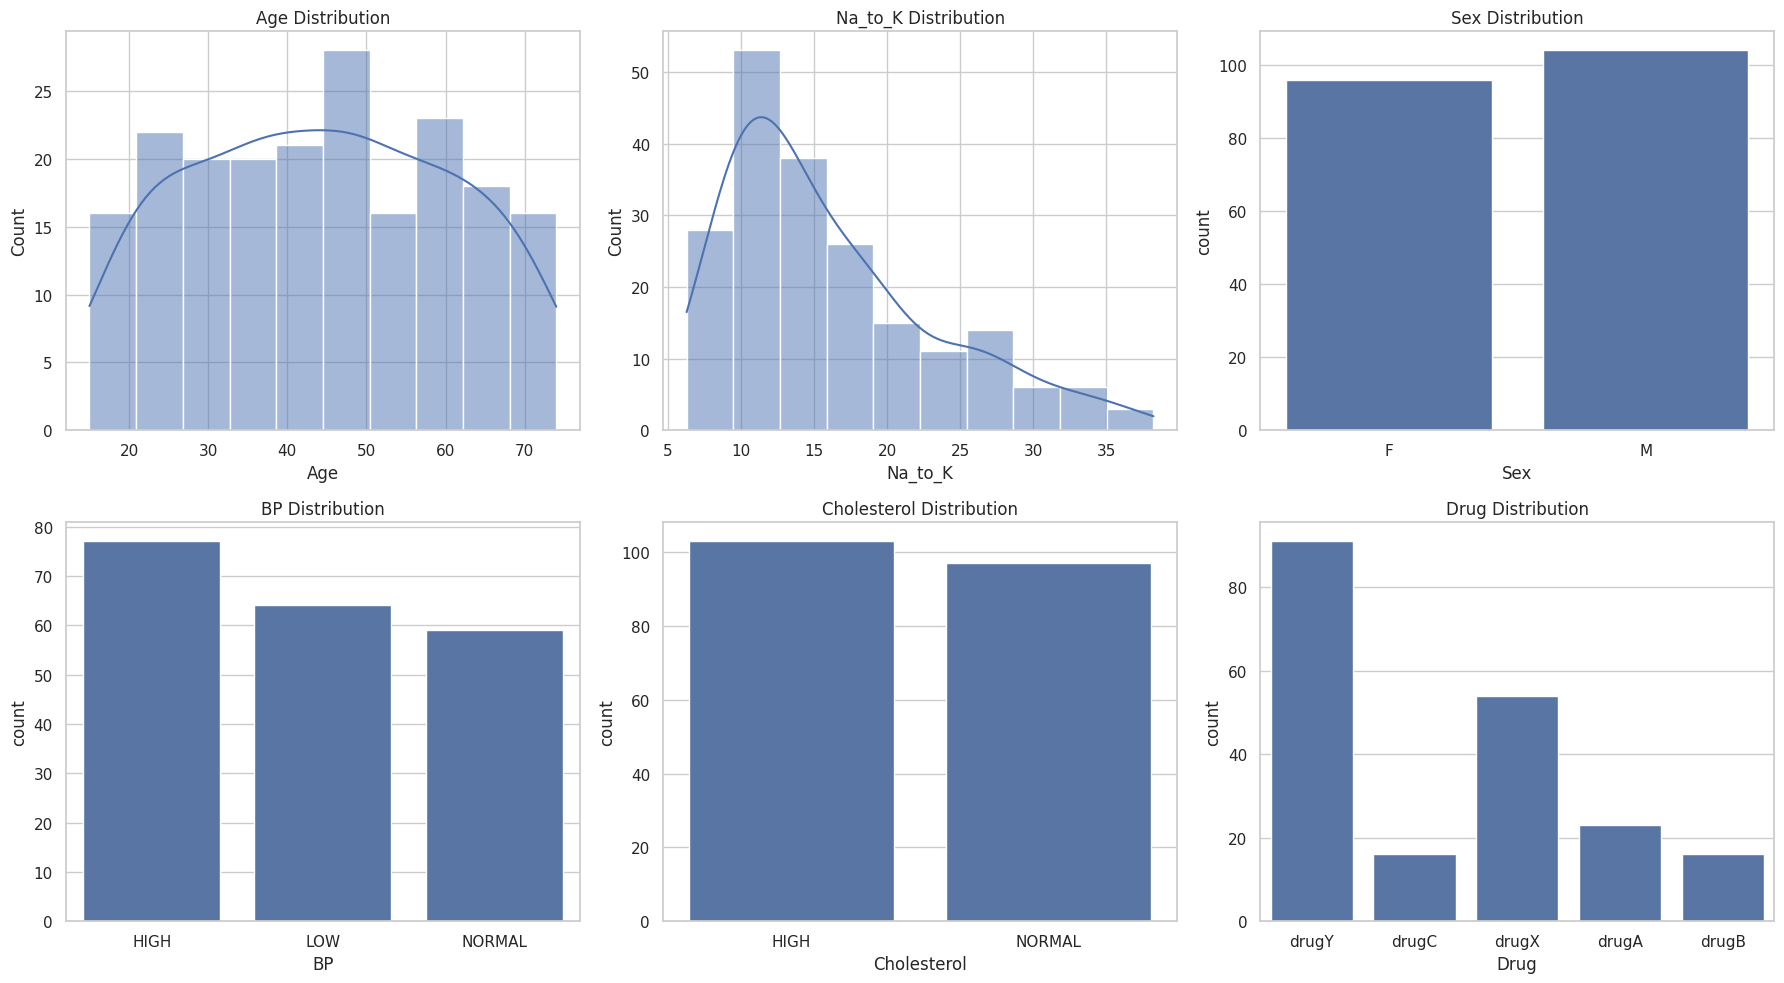

In [11]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Histograms for numerical columns
sns.histplot(df_drug['Age'], bins=10, kde=True, ax=axes[0, 0]).set_title('Age Distribution')
sns.histplot(df_drug['Na_to_K'], bins=10, kde=True, ax=axes[0, 1]).set_title('Na_to_K Distribution')

# Bar plots for categorical columns
sns.countplot(x='Sex', data=df_drug, ax=axes[0, 2]).set_title('Sex Distribution')
sns.countplot(x='BP', data=df_drug, ax=axes[1, 0]).set_title('BP Distribution')
sns.countplot(x='Cholesterol', data=df_drug, ax=axes[1, 1]).set_title('Cholesterol Distribution')
sns.countplot(x='Drug', data=df_drug, ax=axes[1, 2]).set_title('Drug Distribution')

plt.tight_layout()
plt.show()

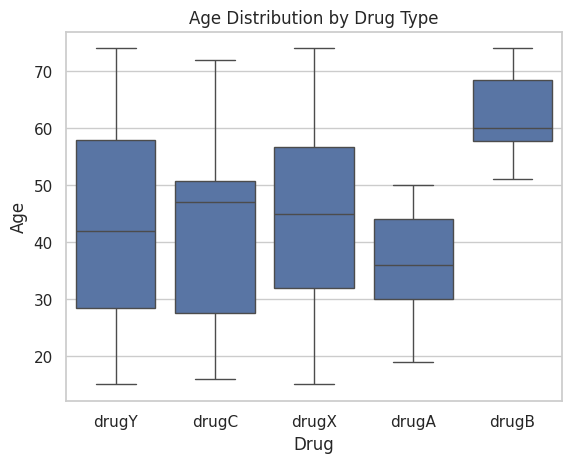

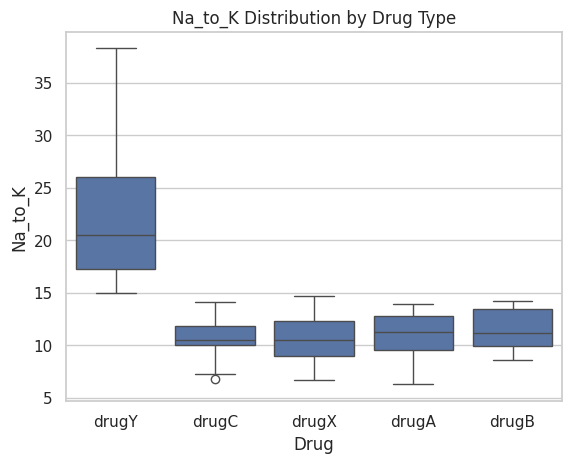

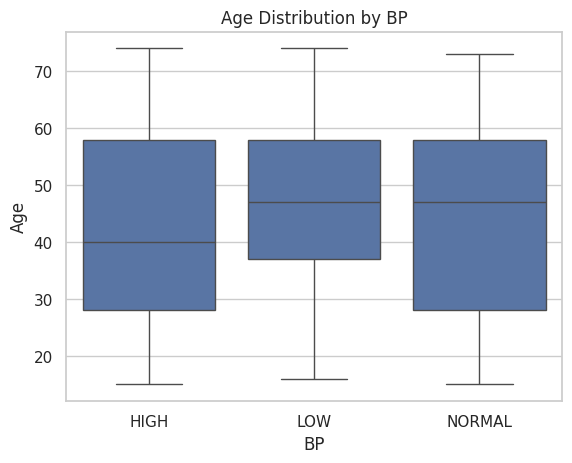

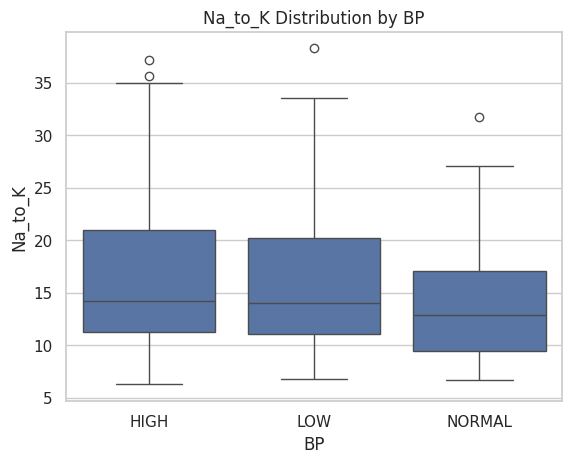

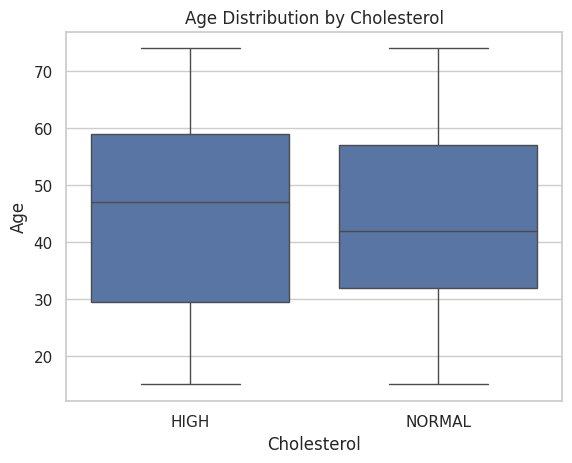

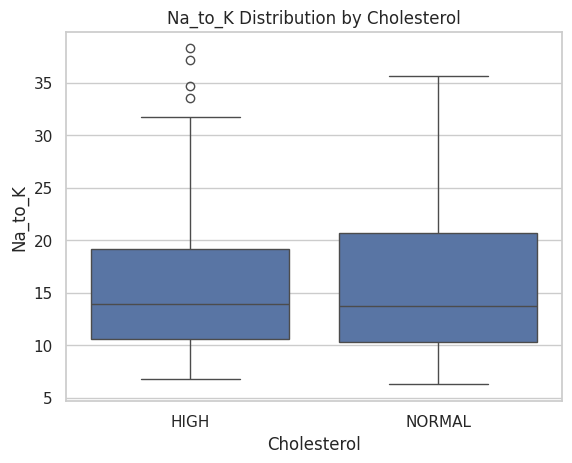

In [12]:
# Box Plot of Age and Na_to_K grouped by Drug, BP, or Cholesterol

sns.boxplot(x='Drug', y='Age', data=df_drug)
plt.title('Age Distribution by Drug Type')
plt.show()

sns.boxplot(x='Drug', y='Na_to_K', data=df_drug)
plt.title('Na_to_K Distribution by Drug Type')
plt.show()

sns.boxplot(x='BP', y='Age', data=df_drug)
plt.title('Age Distribution by BP')
plt.show()

sns.boxplot(x='BP', y='Na_to_K', data=df_drug)
plt.title('Na_to_K Distribution by BP')
plt.show()

sns.boxplot(x='Cholesterol', y='Age', data=df_drug)
plt.title('Age Distribution by Cholesterol')
plt.show()

sns.boxplot(x='Cholesterol', y='Na_to_K', data=df_drug)
plt.title('Na_to_K Distribution by Cholesterol')
plt.show()



Drug Y (blue) seems to be associated with patients who have higher Na_to_K ratios, as most of the blue points are concentrated in the upper part of the plot. Other drugs (drugC, drugX, drugA, drugB) tend to be associated with patients who have lower Na_to_K ratios, with points clustered near the bottom. There doesn’t seem to be a strong age-related pattern within each drug category. Patients prescribed different drugs cover a wide range of ages, though Drug Y patients appear more dispersed across both age and Na_to_K values.

This plot suggests that Na_to_K ratio might be an important factor in determining the type of drug prescribed, as higher ratios are predominantly associated with Drug Y. Age doesn’t appear to be a primary determinant for drug choice since patients across all ages are prescribed various drugs.


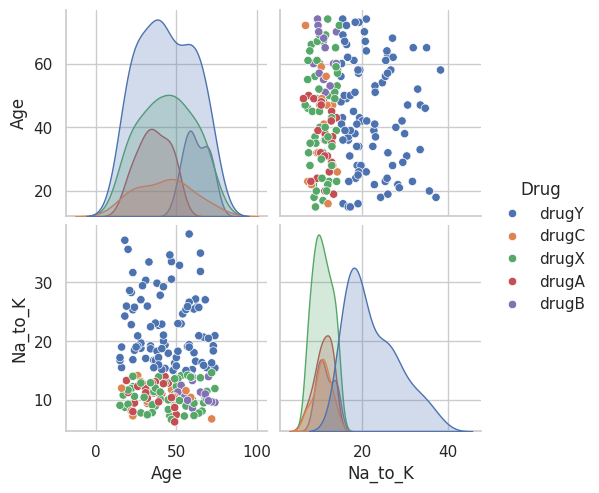

In [13]:
sns.pairplot(df_drug, hue='Drug')
plt.show()



From the pair plot we note that Na_to_K appears to be a significant feature for differentiating drug types: drugY patients generally have higher Na_to_K values, making this feature a strong indicator for drugY prescription. Other drugs (like drugX and drugA) have lower Na_to_K values, suggesting that lower Na_to_K ratios may be associated with these drugs.

Age appears to be less of a defining feature for differentiating drugs: Patients on different drugs are distributed across all ages, with some overlap. However, there might be slight clustering patterns, such as younger patients being prescribed drugX, but this is not as prominent as the Na_to_K differentiation.


# Machine Learning


Preparing the dataset to train models


In [14]:
X = df_drug.drop(["Drug"], axis=1)
y = df_drug["Drug"]

In [15]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter


print("Original class distribution:")
print(Counter(y))


ros = RandomOverSampler(sampling_strategy='auto', random_state=42)


X, y = ros.fit_resample(X, y)


print("Resampled class distribution:")
print(Counter(y))

Original class distribution:
Counter({'drugY': 91, 'drugX': 54, 'drugA': 23, 'drugC': 16, 'drugB': 16})
Resampled class distribution:
Counter({'drugY': 91, 'drugC': 91, 'drugX': 91, 'drugA': 91, 'drugB': 91})


In [16]:
numerical_cols = ['Age', 'Na_to_K']
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
X['Sex'] = label_encoder.fit_transform(X['Sex'])
X['BP'] = label_encoder.fit_transform(X['BP'])
X['Cholesterol'] = label_encoder.fit_transform(X['Cholesterol'])

print(X['Sex'])
print(X['BP'])
print(X['Cholesterol'])


0      0
1      1
2      1
3      0
4      0
      ..
450    1
451    1
452    1
453    0
454    0
Name: Sex, Length: 455, dtype: int64
0      0
1      1
2      1
3      2
4      1
      ..
450    1
451    2
452    1
453    2
454    2
Name: BP, Length: 455, dtype: int64
0      0
1      0
2      0
3      0
4      0
      ..
450    1
451    1
452    1
453    0
454    0
Name: Cholesterol, Length: 455, dtype: int64


In [17]:
y = label_encoder.fit_transform(y)
print(y)

[4 2 2 3 4 3 4 2 4 4 2 4 4 4 3 4 3 0 2 4 4 4 4 4 4 4 4 3 4 4 3 1 3 4 3 3 0
 3 3 3 4 1 4 3 3 3 0 2 4 4 4 3 4 4 1 2 1 4 3 4 4 0 4 3 1 4 0 3 4 4 1 4 3 4
 4 4 0 4 0 3 1 3 2 0 2 1 3 4 4 4 4 4 4 4 4 3 4 4 4 4 0 0 2 3 4 3 3 4 1 4 0
 3 3 3 3 4 3 3 0 4 4 4 4 4 1 4 4 3 4 3 4 4 3 4 4 3 1 0 1 3 0 4 1 4 0 3 3 0
 3 2 0 1 3 3 4 2 0 4 2 3 3 1 3 4 4 4 4 3 4 0 3 3 4 4 0 4 0 4 4 4 4 3 3 4 4
 4 1 0 4 4 4 0 4 2 4 2 2 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3]


# Models


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
print(X_train)

          Age  Sex  BP  Cholesterol   Na_to_K
24  -0.775405    0   1            0  3.611045
17  -0.165747    1   0            0  0.143729
66  -1.019269    1   0            0 -0.054566
304  0.870673    1   0            1 -0.807056
253 -0.470576    0   0            1 -0.326422
..        ...  ...  ..          ...       ...
106 -1.446030    1   2            0 -0.215014
270  0.748741    0   0            1  0.191170
348 -0.287678    1   1            0 -0.377772
435 -0.348644    0   1            1 -0.322335
102 -1.080234    0   1            0 -0.006414

[364 rows x 5 columns]


In [20]:
print(y_train)

[4 0 0 1 0 1 2 1 4 2 2 4 0 2 2 1 3 4 2 3 3 4 4 2 1 3 3 2 1 3 2 3 4 0 0 4 3
 0 1 0 4 2 0 4 2 2 1 1 3 0 3 3 3 0 3 2 4 2 0 2 4 1 0 4 2 4 0 3 0 3 3 3 0 2
 2 3 4 1 4 2 4 1 2 0 1 1 0 4 2 1 0 3 1 3 3 1 4 3 2 0 4 2 1 2 0 4 4 2 0 3 3
 3 1 3 3 2 3 1 2 0 4 4 0 4 1 0 2 4 2 4 2 4 1 4 4 2 2 2 4 2 4 4 3 0 4 4 0 3
 3 1 3 2 2 1 2 1 4 3 3 2 0 0 3 2 0 3 2 0 1 2 2 1 0 2 3 4 1 3 1 3 1 0 1 4 1
 3 0 0 4 4 0 2 2 3 1 2 4 1 2 4 1 3 3 4 1 1 0 1 3 4 3 4 3 1 2 1 0 3 3 0 1 2
 4 1 2 0 1 0 2 4 0 2 0 0 2 0 3 4 1 0 0 2 3 0 1 0 2 3 2 0 0 1 3 2 1 4 3 4 3
 4 1 3 1 1 3 0 4 3 2 0 1 2 1 0 0 0 1 2 0 3 2 1 2 1 0 1 3 0 4 1 0 3 4 2 3 4
 1 0 3 0 2 4 1 3 4 2 0 0 4 1 4 2 1 4 1 3 4 1 3 1 0 1 2 4 0 4 3 0 0 3 4 2 0
 0 4 1 3 1 0 2 1 2 2 0 1 2 4 1 2 4 2 4 1 0 4 3 4 4 4 3 1 2 3 2]


Logistic Regression and Decision Tree


In [21]:
from sklearn.linear_model import LogisticRegression
LRclassifier = LogisticRegression(solver='liblinear', max_iter=5000)
LRclassifier.fit(X_train, y_train)

y_pred = LRclassifier.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import accuracy_score
LRAcc = accuracy_score(y_pred,y_test)
print('Logistic Regression accuracy is: {:.2f}%'.format(LRAcc*100))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        15
           3       0.95      0.95      0.95        20
           4       0.94      0.89      0.92        19

    accuracy                           0.97        91
   macro avg       0.97      0.97      0.97        91
weighted avg       0.97      0.97      0.97        91

[[18  0  0  0  0]
 [ 0 19  0  0  0]
 [ 0  0 15  0  0]
 [ 0  0  0 19  1]
 [ 1  0  0  1 17]]
Logistic Regression accuracy is: 96.70%


In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

DTclassifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
DTclassifier.fit(X_train, y_train)

y_pred = DTclassifier.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

DTAcc = accuracy_score(y_pred,y_test)

print( 'Decision Tree accuracy is: {:.2f}%' .format(DTAcc*100))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        15
           3       1.00      0.95      0.97        20
           4       0.95      1.00      0.97        19

    accuracy                           0.99        91
   macro avg       0.99      0.99      0.99        91
weighted avg       0.99      0.99      0.99        91

[[18  0  0  0  0]
 [ 0 19  0  0  0]
 [ 0  0 15  0  0]
 [ 0  0  0 19  1]
 [ 0  0  0  0 19]]
Decision Tree accuracy is: 98.90%


Neural Networks


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.2357 - loss: 1.6264 - val_accuracy: 0.3407 - val_loss: 1.5466
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4920 - loss: 1.5187 - val_accuracy: 0.4945 - val_loss: 1.4680
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5764 - loss: 1.4393 - val_accuracy: 0.6374 - val_loss: 1.3865
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6194 - loss: 1.3629 - val_accuracy: 0.6374 - val_loss: 1.2914
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6313 - loss: 1.2894 - val_accuracy: 0.6484 - val_loss: 1.1824
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6940 - loss: 1.1778 - val_accuracy: 0.7363 - val_loss: 1.0580
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7629 - loss: 1.0175 - val_accuracy: 0.7802 - val_loss: 0.9144
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7940 - loss: 0.9187 - val_accuracy: 0.8791 - val_loss: 0.7655
E

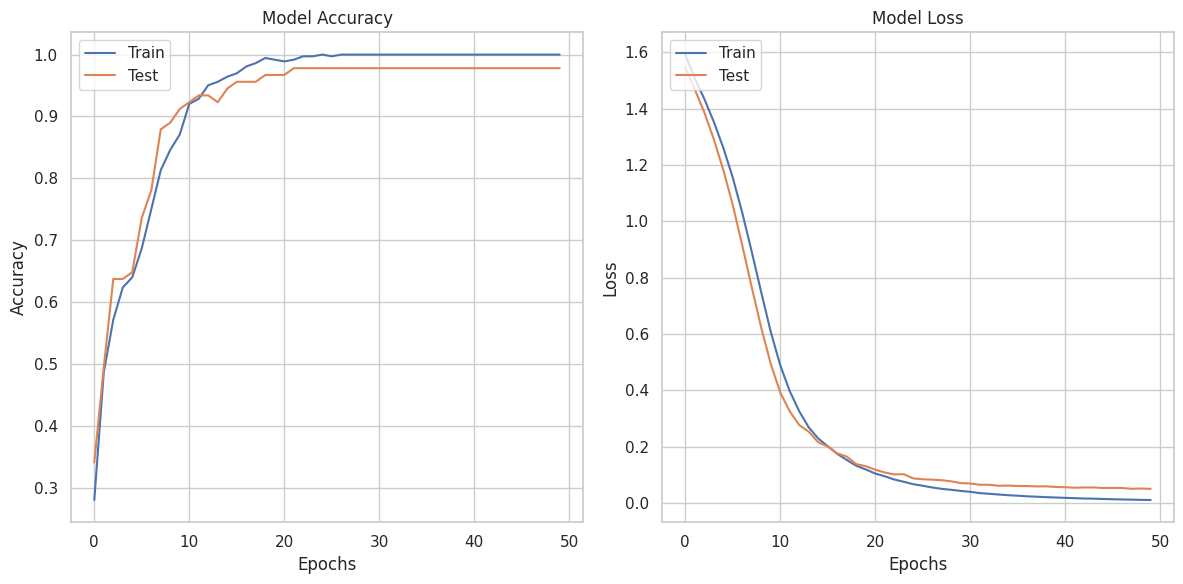

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report



model = Sequential()


model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))


model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))


model.add(Dense(len(np.unique(y)), activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
              optimizer=Adam(),
              metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels


print("Classification Report:")
print(classification_report(y_test, y_pred_classes))


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


# Variations of the model


Adaptive learning rate

Epoch 1/70


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.2259 - loss: 1.6135 - val_accuracy: 0.3077 - val_loss: 1.5253 - learning_rate: 0.0010
Epoch 2/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3943 - loss: 1.5067 - val_accuracy: 0.4286 - val_loss: 1.4324 - learning_rate: 0.0010
Epoch 3/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4378 - loss: 1.4185 - val_accuracy: 0.4505 - val_loss: 1.3347 - learning_rate: 0.0010
Epoch 4/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4747 - loss: 1.3160 - val_accuracy: 0.4835 - val_loss: 1.2347 - learning_rate: 0.0010
Epoch 5/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5264 - loss: 1.2286 - val_accuracy: 0.4945 - val_loss: 1.1151 - learning_rate: 0.0010
Epoch 6/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5167 - loss: 1.1267 - val_accuracy: 0.5165 - val_loss: 0.9945 - learning_rate: 0.0010
Epoch 7/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5919 - loss: 0.9836 - val_accuracy: 0.6923 -

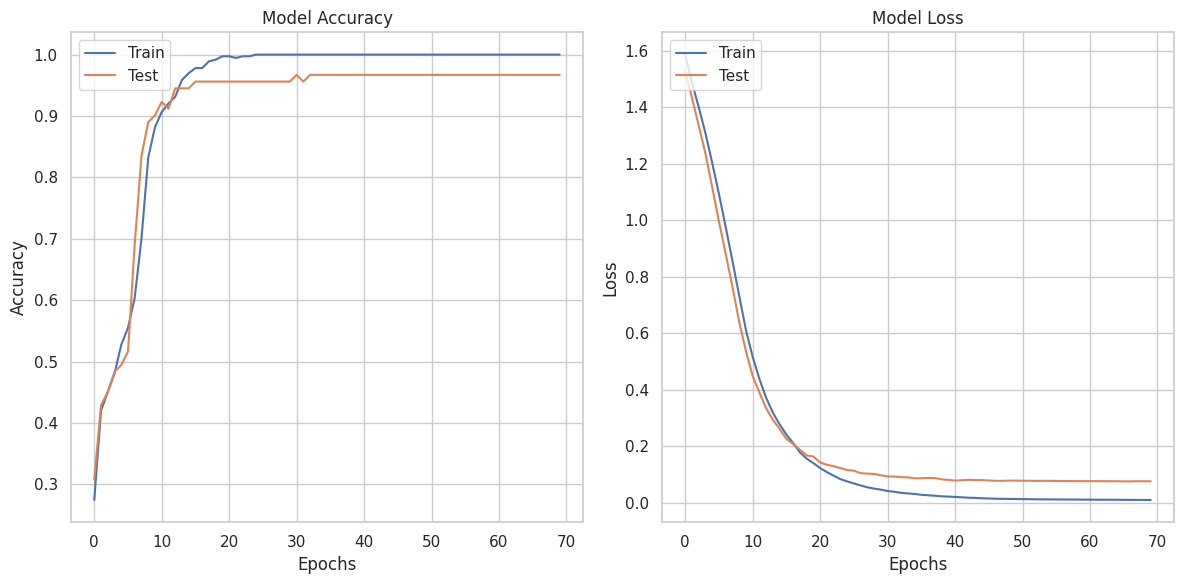

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = Sequential()


model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))


model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))


model.add(Dense(len(np.unique(y)), activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
              optimizer=Adam(),
              metrics=['accuracy'])


reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,         # Reduce learning rate by a factor of 0.5
                              patience=5,         # Wait 5 epochs before reducing LR
                              min_lr=1e-6,        # Lower bound for the learning rate
                              verbose=1)

history = model.fit(X_train, y_train, epochs=70, batch_size=32,
                    validation_data=(X_test, y_test), verbose=1,
                    callbacks=[reduce_lr])


loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")


y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


print("Classification Report:")
print(classification_report(y_test, y_pred_classes))


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


Dropout

Epoch 1/70


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.1512 - loss: 1.6730 - val_accuracy: 0.3077 - val_loss: 1.5503
Epoch 2/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3117 - loss: 1.5569 - val_accuracy: 0.6703 - val_loss: 1.4670
Epoch 3/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3636 - loss: 1.5084 - val_accuracy: 0.7363 - val_loss: 1.3798
Epoch 4/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4932 - loss: 1.4146 - val_accuracy: 0.7363 - val_loss: 1.2905
Epoch 5/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5058 - loss: 1.3460 - val_accuracy: 0.7692 - val_loss: 1.2058
Epoch 6/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5579 - loss: 1.2633 - val_accuracy: 0.8571 - val_loss: 1.1320
Epoch 7/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5383 - loss: 1.2090 - val_accuracy: 0.8571 - val_loss: 1.0505
Epoch 8/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5505 - loss: 1.1765 - val_accuracy: 0.8791 - val_loss: 0.9699


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        15
           3       1.00      0.95      0.97        20
           4       0.95      1.00      0.97        19

    accuracy                           0.99        91
   macro avg       0.99      0.99      0.99        91
weighted avg       0.99      0.99      0.99        91



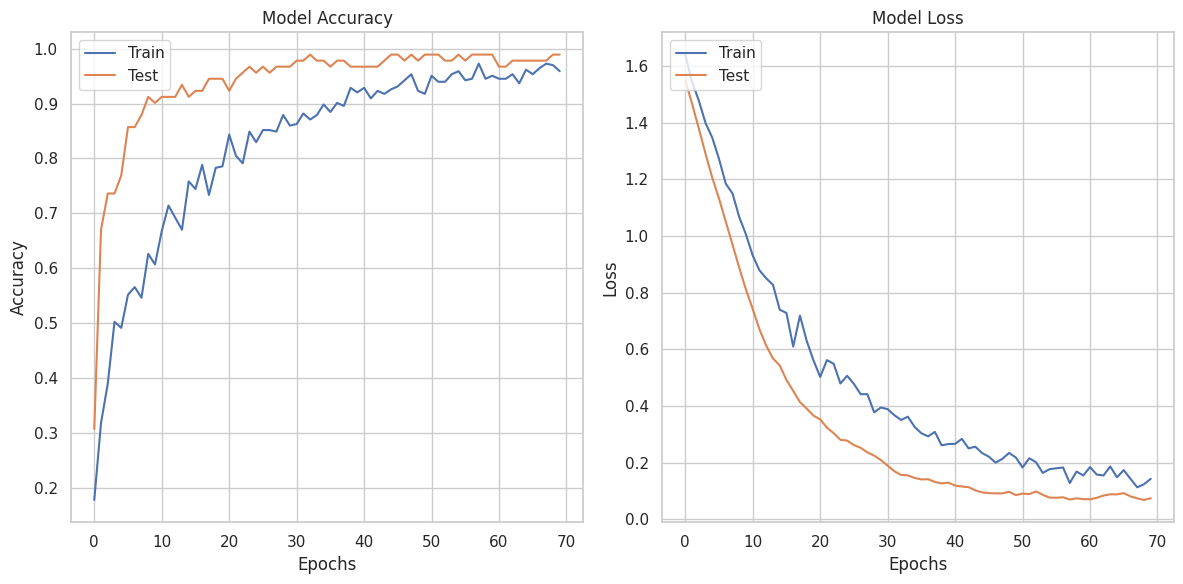

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = Sequential()


model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))


model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))  # Adding dropout with a rate of 0.3 after first hidden layer

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))  # Adding dropout with a rate of 0.3 after second hidden layer


model.add(Dense(len(np.unique(y)), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=70, batch_size=32, validation_data=(X_test, y_test), verbose=1)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")


y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels


print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


Using Tanh as activation function

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4079 - loss: 1.4590 - val_accuracy: 0.6923 - val_loss: 1.1795
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7005 - loss: 1.1369 - val_accuracy: 0.7692 - val_loss: 0.9627
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7015 - loss: 0.9646 - val_accuracy: 0.8462 - val_loss: 0.8181
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7611 - loss: 0.8547 - val_accuracy: 0.8571 - val_loss: 0.7153
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8559 - loss: 0.7383 - val_accuracy: 0.8901 - val_loss: 0.6302
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8937 - loss: 0.6469 - val_accuracy: 0.9231 - val_loss: 0.5603
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9440 - loss: 0.5763 - val_accuracy: 0.9560 - val_loss: 0.5041
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9530 - loss: 0.5386 - val_accuracy: 0.9560 - val_loss: 0.45

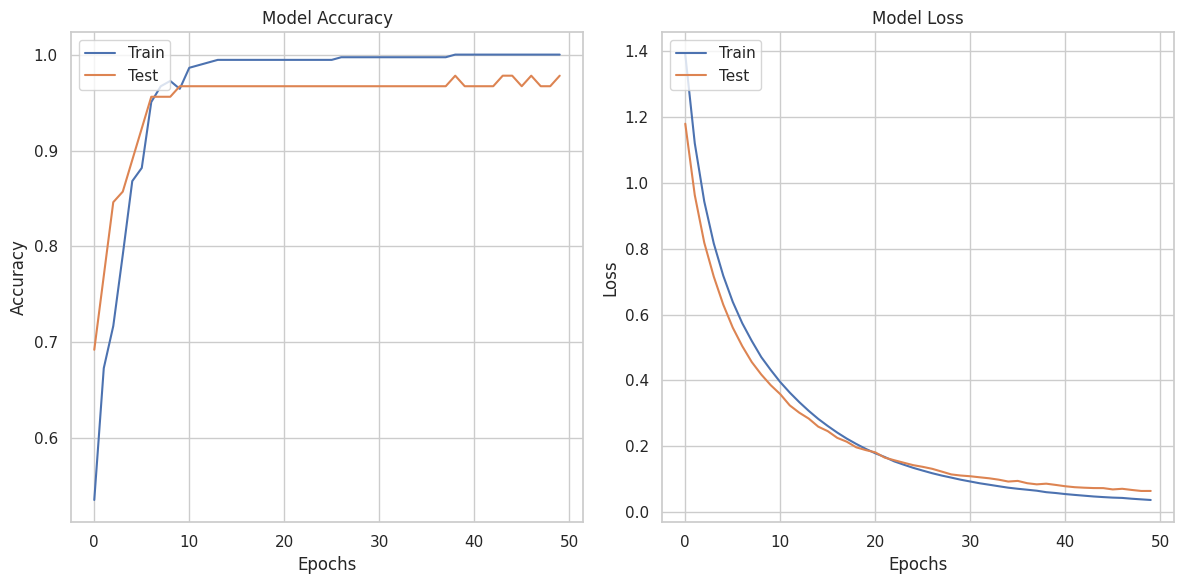

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()

model.add(Dense(64, input_dim=X_train.shape[1], activation='tanh'))

model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))


model.add(Dense(len(np.unique(y)), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


# Using Validation Set


Training set size: (318, 5)
Validation set size: (68, 5)
Test set size: (69, 5)
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.2182 - loss: 1.6285 - val_accuracy: 0.2794 - val_loss: 1.5654
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3181 - loss: 1.5393 - val_accuracy: 0.4412 - val_loss: 1.5006
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5294 - loss: 1.4712 - val_accuracy: 0.4853 - val_loss: 1.4319
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5293 - loss: 1.4017 - val_accuracy: 0.5588 - val_loss: 1.3583
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5791 - loss: 1.3047 - val_accuracy: 0.6029 - val_loss: 1.2729
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6309 - loss: 1.2334 - val_accuracy: 0.6765 - val_loss: 1.1701
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6840 - loss: 1.1001 - val_accuracy: 0.7206 - val_loss: 1.0589
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8104 - loss: 0.9994 - val_accuracy: 0.7647 - val_loss: 0.

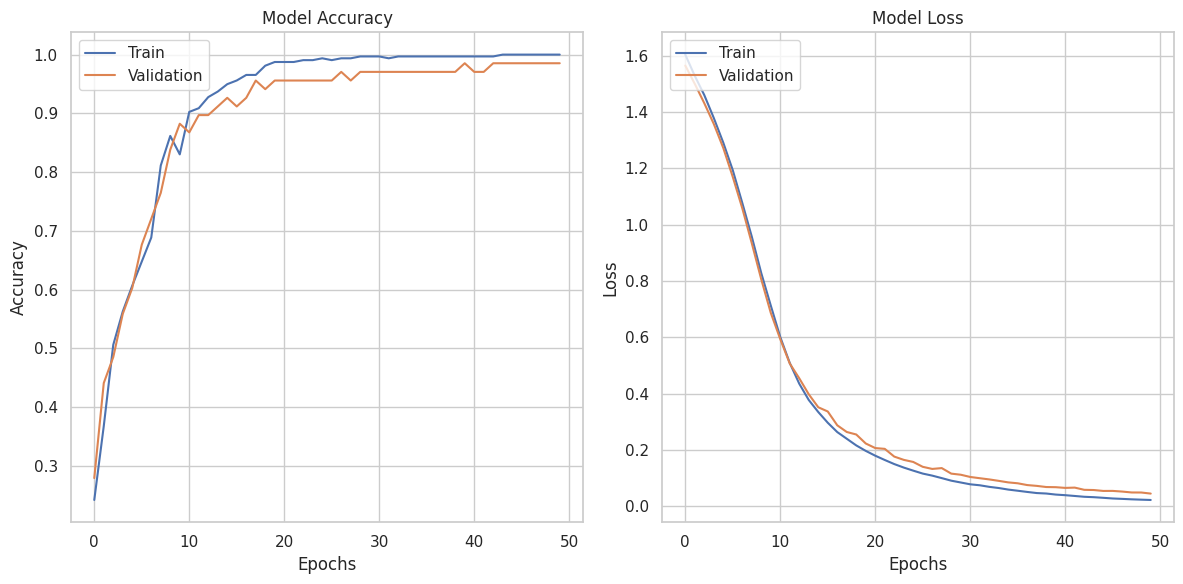

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")


model = Sequential()


model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))


model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))

model.add(Dense(len(np.unique(y)), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
              optimizer=Adam(),
              metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)


loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")


y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


print("Classification Report:")
print(classification_report(y_test, y_pred_classes))


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Dropout + validation set

Epoch 1/70


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.2110 - loss: 1.6643 - val_accuracy: 0.3836 - val_loss: 1.5394
Epoch 2/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2803 - loss: 1.5812 - val_accuracy: 0.4658 - val_loss: 1.4825
Epoch 3/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3521 - loss: 1.5382 - val_accuracy: 0.6301 - val_loss: 1.4298
Epoch 4/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4203 - loss: 1.4565 - val_accuracy: 0.7123 - val_loss: 1.3725
Epoch 5/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4666 - loss: 1.3891 - val_accuracy: 0.7123 - val_loss: 1.3155
Epoch 6/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4705 - loss: 1.3632 - val_accuracy: 0.7945 - val_loss: 1.2599
Epoch 7/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5377 - loss: 1.2853 - val_accuracy: 0.7671 - val_loss: 1.2012
Epoch 8/70
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5715 - loss: 1.2585 - val_accuracy: 0.7534 - val_loss: 1.

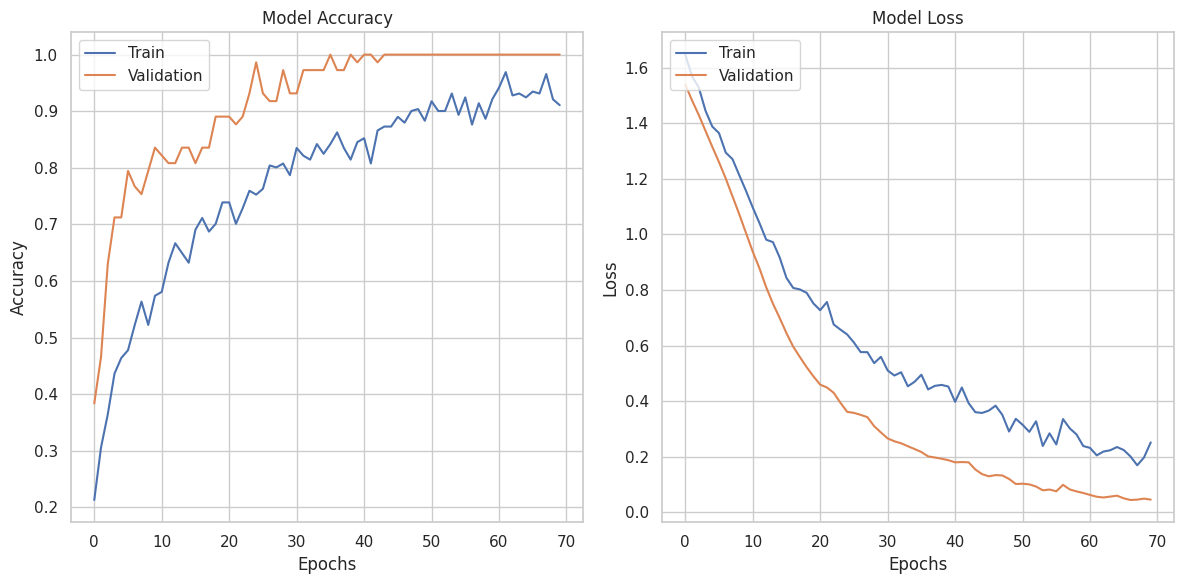

In [28]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


model = Sequential()

model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(np.unique(y)), activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
              optimizer=Adam(),
              metrics=['accuracy'])

# Train the model with validation set
history = model.fit(X_train, y_train,
                    epochs=70,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    verbose=1)


loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")


y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

print("Classification Report:")
print(classification_report(y_test, y_pred_classes))


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


# PCA and CLUSTERING


In [29]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import pandas as pd

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_pca)

y_kmeans = kmeans.predict(X_pca)

df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2', 'PCA3'])
df_pca['Cluster'] = y_kmeans

fig = px.scatter_3d(df_pca, x='PCA1', y='PCA2', z='PCA3', color='Cluster',
                    title="3D Clustering with PCA Reduction",
                    labels={"PCA1": "PCA Component 1", "PCA2": "PCA Component 2", "PCA3": "PCA Component 3"})

fig.show()
